# Prototipo Buscador `Editorial Uptc`

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python

In [2]:
from langchain_openai import ChatOpenAI
gpt4o_chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [3]:
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

In [4]:
import pymongo as pymg
myclient = pymg.MongoClient("mongodb://localhost:27017/")
mydb = myclient['editorial']
mycol = mydb['libros']

In [5]:

def buscar_por_titulo(palabras: str):
    """
    Busca libros cuyo título se encutren en la base de datos,
    extraídas apartir de palabras relevantes.

    Args:
        palabras (str): Palabras claves, separadas por una ',' en String. ejemplo: 'aulas,interdiciplinares'. ademas corrige la ortografia si es necesario.

    Returns:
        list: Lista de documentos que coinciden con la búsqueda.
    """
    print(palabras)
    if ',' not in palabras:
        return list(mycol.find({'title':{'$regex':palabras,'$options':'i'}}))
    else:
        palabras_clave = palabras.split(',') 
        condiciones_or = [{"title": {"$regex": palabra, "$options": "i"}} for palabra in palabras_clave]
        if not condiciones_or: 
            return []
        
        return list(mycol.find({"$or": condiciones_or}))

# La lista de tools y la inicialización del LLM se mantienen igual
tools = [buscar_por_titulo]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [6]:
#system message
content= '''Eres un Asistente en una biblioteca encargado 
    de buscar informacion de libros responde de forma resumida con el titulo del libro el autor y
    una pequeña descripcion del libro, adiciona la url para que el usuario pueda ver mas informacion,
    simpre procura buscar como titulo de libro.

    Si no saber la respuesta dilo.
'''
sys_msg = SystemMessage(content=content)

# node 
def assistant(state: MessagesState):
    return{'messages':[llm_with_tools.invoke([sys_msg] +state['messages'])]}

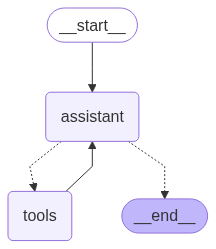

In [7]:
#graph
builder = StateGraph(MessagesState)
builder.add_node('assistant', assistant)
builder.add_node('tools',ToolNode(tools))
builder.set_entry_point('assistant')
# define las aristas
builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',tools_condition)
builder.add_edge("tools", "assistant")
react_graph= builder.compile()
#run
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## prueba

In [9]:
messages = [HumanMessage(content="probabilidad")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

probabilidad
================================ Human Message =================================

probabilidad
================================== Ai Message ==================================
Tool Calls:
  buscar_por_titulo (call_747YH6dwS1YShD22G99KK5LP)
 Call ID: call_747YH6dwS1YShD22G99KK5LP
  Args:
    palabras: probabilidad
================================= Tool Message =================================
Name: buscar_por_titulo

[{'_id': ObjectId('683c39e1db7d83a3a59b5d85'), 'title': 'Introducción al cálculo de probabilidades para estudiantes de ingeniería', 'colaboradores': ['Alex L. Rojas'], 'precio': None, 'palabras_clave': ['Espacio muestral', 'Probabilidad', 'Probabilidad condicional', 'Variables aleatorias', 'Funciones de distribución', 'Función de fiabilidad', 'Función cuantil'], 'doi': None, 'descripcion': ['\nEl propósito de este libro es servir de texto guía en cursos de probabilidad para estudiantes de ingeniería. Por esta razón, los conceptos presentados son principalmente

In [18]:
m.content


'Aquí tienes algunos libros relacionados con "conjuntos":\n\n1. **Cálculo y medición de probabilidades**\n   - **Autores:** Margoth Adriana Valdivieso Miranda, Víctor Miguel Ángel Burbano Pantoja\n   - **Descripción:** Este libro aborda la evolución del cálculo de probabilidades y su enseñanza desde la educación básica hasta la universitaria, incluyendo metodologías innovadoras para mejorar el aprendizaje de los estudiantes.\n   - **[Más información](https://editorial.uptc.edu.co/gpd-calculo-y-medicion-de-probabilidades-9789586608312-6643c51dcb3c6.html)**\n\n2. **Iniciando a Programar con Python**\n   - **Autores:** Javier Humberto Cuervo Álvarez, Lina María Cuervo Díaz, Nathalia Andrea Cuervo Díaz\n   - **Descripción:** Una guía básica para aprender programación en Python, cubriendo desde temas elementales hasta estructuras de datos como listas, conjuntos y diccionarios.\n   - **[Más información](https://editorial.uptc.edu.co/gpd-iniciando-a-programar-con-python-9789586609036-66edebb6

In [ ]:
!pip install gradio

In [9]:
import gradio as gr

In [10]:
def buscar_libro(texto):
    messages = [HumanMessage(content=texto)]
    messages = react_graph.invoke({"messages": messages})
    return messages['messages'][-1].content


with gr.Blocks() as demo:
    gr.Markdown('## Buscador de Libros Editorial UPTC 📚 🔎')
    
    with gr.Row():
        # Caja de texto y botón en la misma fila
        texto_busqueda = gr.Textbox(
            placeholder='Ingresa palabras clave para buscar...',
            label='Búsqueda',
            scale=4  # La caja de texto ocupará más espacio
        )
        boton_buscar = gr.Button("🔍 Buscar", scale=1)  
    
    # Área de resultados
    resultados = gr.Markdown(
        label="Resultados"
    )
    
    # Conectar el botón con la función de búsqueda
    boton_buscar.click(
        fn=buscar_libro,
        inputs=texto_busqueda,
        outputs=resultados
    )

# Lanzar la interfaz
demo.launch() 


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


poemas raros
contabilidad
contabilidad
probabilidad
poemas raros
